In [1]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import os
import itertools
import joblib
from datetime import datetime

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def agregar_lags(df, columna, lags):
    for lag in lags:
        df[f'lag_{lag}'] = df[columna].shift(lag)
    return df

def agregar_medias_moviles(df, columna, ventanas):
    for ventana in ventanas:
        df[f'media_movil_{ventana}'] = df[columna].shift(1).rolling(window=ventana, min_periods=1).mean()
    return df

def agregar_variables_ciclicas(df, columna_mes, columna_fecha):
    df['mes_sin'] = np.sin(2 * np.pi * df[columna_mes] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df[columna_mes] / 12)
    df['dia_semana_sin'] = np.sin(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    return df

def agregar_ewma(df, columna, spans):
    for span in spans:
        df[f'ewma_{span}'] = df[columna].shift(1).ewm(span=span, adjust=False).mean()
    return df

def obtener_semestre(mes):
    if 3 <= mes <= 7:
        return 1
    elif 8 <= mes <= 12:
        return 2
    else:
        return 0

def semana_en_semestre(row):
    if row['Semestre'] == 1:
        inicio = pd.Timestamp(year=row['Año'], month=3, day=1)
    elif row['Semestre'] == 2:
        inicio = pd.Timestamp(year=row['Año'], month=8, day=1)
    else:
        return np.nan
    return ((row['Fecha'] - inicio).days // 7) + 1

In [3]:
try:
    daily_counts_full = pd.read_csv("../Datasets/accesos_biblioteca.csv")
    print("Dataset cargado desde '../Datasets/accesos_biblioteca.csv'")
except FileNotFoundError:
    print("ERROR: No se encontró el archivo 'accesos_biblioteca.csv'.")
    exit(1)

#  Feature Engineering 
for col in ['Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)
daily_counts_full['Fecha'] = pd.to_datetime(daily_counts_full['Fecha'])
daily_counts_full = daily_counts_full[
    daily_counts_full['Fecha'].dt.weekday != 6 
].reset_index(drop=True)

daily_counts_full = agregar_medias_moviles(daily_counts_full, 'Accesos', [7, 14, 30])
daily_counts_full = agregar_variables_ciclicas(daily_counts_full, 'Mes', 'Fecha')
daily_counts_full = agregar_ewma(daily_counts_full, 'Accesos', [7, 14, 30])
daily_counts_full['Semestre'] = daily_counts_full['Mes'].apply(obtener_semestre)
daily_counts_full['Semana_Semestre'] = daily_counts_full.apply(semana_en_semestre, axis=1)
daily_counts_full['Semana_Certamen'] = daily_counts_full['Semana_Semestre'].isin([6, 7]).astype(int)
daily_counts_full = agregar_lags(daily_counts_full, 'Accesos', [7, 14, 21])


# Preparación del DF en formato Prophet (ds, y)
data_prophet = daily_counts_full.set_index('Fecha').dropna().copy()
data_prophet.rename(columns={'Accesos': 'y'}, inplace=True)
data_prophet['ds'] = data_prophet.index

# Conjunto completo de features (exógenas/regresores)
FEATURES = ['Semana_Certamen', 'media_movil_7', 'media_movil_14', 'media_movil_30',
            'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos',
            'lag_7', 'lag_14', 'lag_21', 'ewma_7', 'ewma_14', 'ewma_30']

# División de datos original 
split_point = int(len(data_prophet) * 0.8)

train_df = data_prophet.iloc[:split_point]
test_df = data_prophet.iloc[split_point:]

y_test = test_df['y']
X_test = test_df.drop(columns=['y'])

print(f"\n Preparación de Datos Finalizada ")
print(f"Prophet: Datos de entrenamiento: {len(train_df)} - Datos de prueba: {len(test_df)}")

Dataset cargado desde '../Datasets/accesos_biblioteca.csv'

 Preparación de Datos Finalizada 
Prophet: Datos de entrenamiento: 256 - Datos de prueba: 64


In [4]:
import itertools
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import timedelta

initial_train_period = '730 days'
period_step = '180 days' 
horizon = '90 days'             

param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.3], 
    'seasonality_prior_scale': [1.0, 5.0, 10.0, 40.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'holidays_prior_scale': [3.0, 10.0, 20.0], 
    'regressor_prior_scale': [0.5, 5.0, 20.0], 
    'yearly_seasonality_fourier_order': [5, 10, 25],
    'weekly_seasonality_fourier_order': [5, 10, 20],
}

fourier_orders_yearly = param_grid.pop('yearly_seasonality_fourier_order')
fourier_orders_weekly = param_grid.pop('weekly_seasonality_fourier_order')
regressor_scales = param_grid.pop('regressor_prior_scale')
param_grid_constructor = param_grid

all_params_constructor = [dict(zip(param_grid_constructor.keys(), v)) for v in itertools.product(*param_grid_constructor.values())]

rmses = []
best_rmse_cv = float("inf")
best_params = {} 

total_combinations = len(fourier_orders_yearly) * len(fourier_orders_weekly) * len(regressor_scales) * len(all_params_constructor)
print(f"\nIniciando ajuste de hiperparámetros de Prophet (Aprox. {total_combinations} combinaciones)...")

for order_y in fourier_orders_yearly:
    for order_w in fourier_orders_weekly:
        for reg_scale in regressor_scales:
            for params in all_params_constructor:
                try:
                    combined_params = params.copy()
                    combined_params['yearly_seasonality_fourier_order'] = order_y
                    combined_params['weekly_seasonality_fourier_order'] = order_w
                    combined_params['regressor_prior_scale'] = reg_scale

                    m = Prophet(**params, 
                                weekly_seasonality=False,
                                daily_seasonality=False,
                                yearly_seasonality=False) 

                    m.add_seasonality(
                        name='yearly', 
                        period=365.25, 
                        fourier_order=order_y
                    )
                    
                    m.add_seasonality(
                        name='weekly', 
                        period=7, 
                        fourier_order=order_w
                    )

                    for feature in FEATURES:
                        m.add_regressor(feature, prior_scale=reg_scale)
                    df_cv = cross_validation(
                        m, 
                        initial=initial_train_period, 
                        period=period_step, 
                        horizon=horizon, 
                    )
                    
                    df_p = performance_metrics(df_cv, metrics=['rmse'], rolling_window=0.1)
                    mean_rmse_cv = df_p['rmse'].mean() 
                    
                    rmses.append(mean_rmse_cv)
                    
                    if mean_rmse_cv < best_rmse_cv:
                        best_rmse_cv = mean_rmse_cv
                        best_params = combined_params
                    
                    print(f"Prophet {combined_params} RMSE_CV: {mean_rmse_cv:.2f}")

                except Exception as e:
                    print(f"Error con parámetros {combined_params}: {e}")
                    continue

print(f'\nResultado de la Optimización')
print(f'Mejores parámetros para Prophet: {best_params}')
print(f'Mejor RMSE de Validación Cruzada: {best_rmse_cv:.2f}')


Iniciando ajuste de hiperparámetros de Prophet (Aprox. 2592 combinaciones)...
Error con parámetros {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 3.0, 'yearly_seasonality_fourier_order': 5, 'weekly_seasonality_fourier_order': 5, 'regressor_prior_scale': 0.5}: Model has not been fit. Fitting the model provides contextual parameters for cross validation.
Error con parámetros {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5, 'weekly_seasonality_fourier_order': 5, 'regressor_prior_scale': 0.5}: Model has not been fit. Fitting the model provides contextual parameters for cross validation.
Error con parámetros {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 20.0, 'yearly_seasonality_fourier_order': 5, 'weekly_seasonality_fourier_

In [5]:
print("\nEntrenando modelo Prophet final")
params_for_prophet = best_params.copy()
fourier_order_value = params_for_prophet.pop('yearly_seasonality_fourier_order', None)

model_prophet = Prophet(**params_for_prophet, 
                        weekly_seasonality=True, 
                        daily_seasonality=False,
                        yearly_seasonality=False)

if fourier_order_value is not None:
    model_prophet.add_seasonality(
        name='yearly', 
        period=365.25, 
        fourier_order=fourier_order_value
    )
else:
    print("Error con best_params")

for feature in FEATURES:
    model_prophet.add_regressor(feature)

model_prophet.fit(train_df)
future = test_df[['ds'] + FEATURES]
forecast = model_prophet.predict(future)
prophet_predicted = np.maximum(forecast['yhat'], 0).values

mse = mean_squared_error(y_test, prophet_predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, prophet_predicted)
r2 = r2_score(y_test, prophet_predicted)

print("\n Evaluación de rendimiento de Prophet en el set de prueba ")
print(f"R²: {r2:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Cuadrático Medio Raíz (RMSE): {rmse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")


Entrenando modelo Prophet final
Error con best_params


23:33:34 - cmdstanpy - INFO - Chain [1] start processing
23:33:36 - cmdstanpy - INFO - Chain [1] done processing



 Evaluación de rendimiento de Prophet en el set de prueba 
R²: 0.64
Error Cuadrático Medio (MSE): 788297.97
Error Cuadrático Medio Raíz (RMSE): 887.86
Error Absoluto Medio (MAE): 681.13


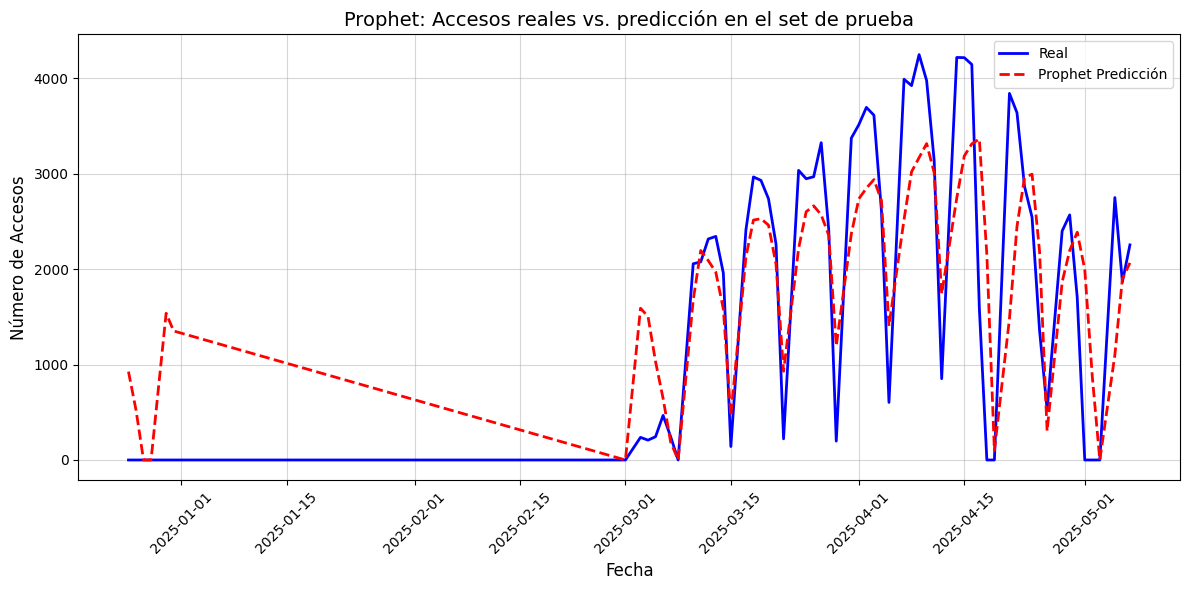


Se ha generado la visualización de la predicción de Prophet.


In [6]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Real', color='blue', linewidth=2)
plt.plot(y_test.index, prophet_predicted, label='Prophet Predicción', color='red', linestyle='--', linewidth=2)
plt.title('Prophet: Accesos reales vs. predicción en el set de prueba', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Accesos', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

print("\nSe ha generado la visualización de la predicción de Prophet.")